In [10]:
# import main class and plotting function
from qdarts.experiment import Experiment
from qdarts.plotting import plot_polytopes

### Data generation test

In [ ]:
Ndots = 3
Nsensors = 1
d_min  = 60

params = {
    # GEOMETRY PARAMETERS
    "d_mean_nm": 100.0,        # Mean distance between dots in nanometers
    "d_std_nm": 20.0,          # Standard deviation of inter-dot distances in nanometers
    "d_min_nm": 60.0,          # Minimum allowed distance between dots (overlap threshold) in nanometers
    
    # SENSOR CONFIGURATION
    "sensor_idx": 3,           # Index of the sensor dot (typically the last dot, 0-indexed)
    "sensor_gate_idx": 3,      # Index of the sensor gate (typically same as sensor_idx)
    
    # PARASITIC CAPACITANCE OF THE QUBIT
    "C0_q_mean": 8*1e-18,
    "C0_q_std": 2*1e-18,

    "C0_s_mean": 30*1e-18,
    "C0_s_std": 1*1e-18,

    
    # DOT-DOT MUTUAL CAPACITA @d_mean
    "Cm_qq_mean": 8e-18,     
    "Cm_qq_std": 3e-18,     
    "Cm_sq_mean": 1.5e-18,    
    "Cm_sq_std": 0.3e-18,     

    
    # GATE CAPACITANCE PARAMETERS (C_DG)
    "C_dg_diag_mean": 10e-18,  
    "C_dg_diag_std": 3*1e-18,  
    "C_dg_sensor_gate_fixed": 50e-18,  

    # TUNNEL COUPLING PARAMETERS (tc)
    "tc_max_meV": 1,
    "tc_x0": d_min,
    "att_per_nm": 0.08   #tmax *exp(-alpha(x-x0)) 0.05-> 10ueV @ 100
                                     
}


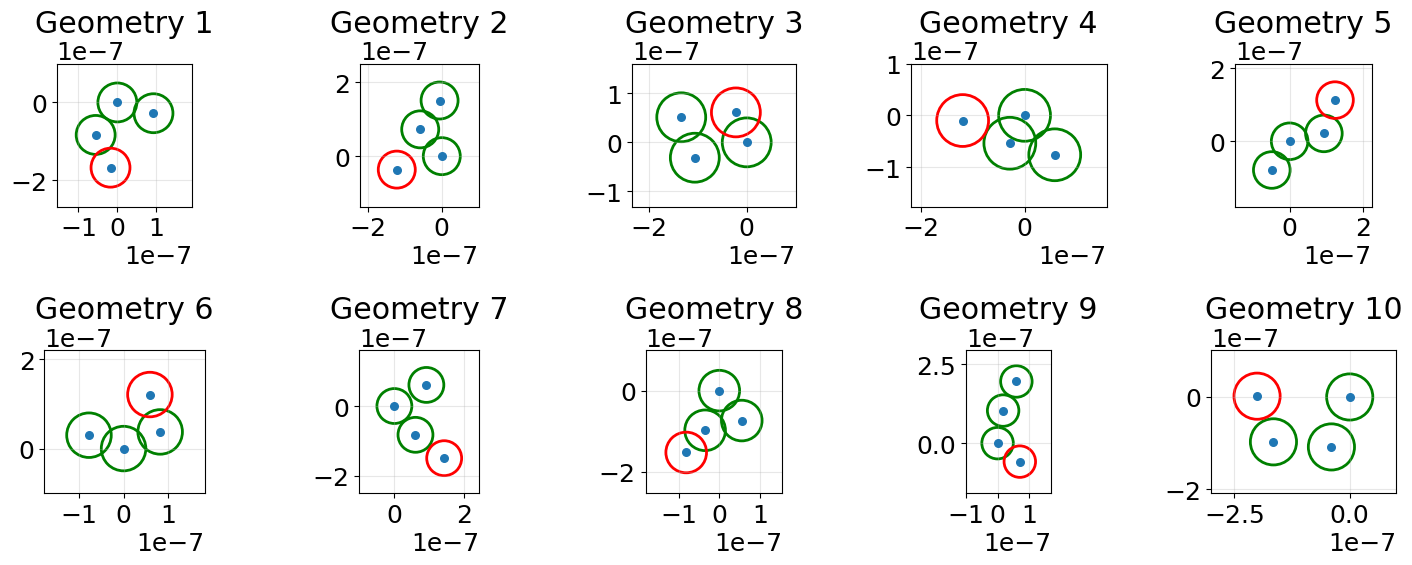

In [12]:
from data_generation import QuantumDotModel, get_virtual_gate_transitions, get_coulomb_diamond_sizes
Qdots = QuantumDotModel(Ndots+Nsensors, Ndots+Nsensors, params)

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

all_distances, all_coords = Qdots._generate_dot_distances_2d_batch(Nconfigurations=10000)
# Plot circles of radius 30 nm (converted to meters) centered at coords.
# For first 3 indices (0, 1, 2), use green; for the rest, red.


# Create a grid of subplots (2 rows, 5 columns)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()  # Flatten to 1D array for easier indexing

radius_nm = 50
radius_m = radius_nm * 1e-9

# Plot each geometry in its own subplot
for idx in range(10):
    ax = axes[idx]
    coords = all_coords[idx]  # Shape: (Nd, 2)
    
    # Plot circles for each dot
    for i in range(coords.shape[0]):
        color = 'green' if i < 3 else 'red'
        circle = mpatches.Circle((coords[i, 0], coords[i, 1]), radius=radius_m, 
                                 fill=False, edgecolor=color, linewidth=2)
        ax.add_patch(circle)
    
    # Plot scatter points
    ax.scatter(coords[:, 0], coords[:, 1], s=30, zorder=3)
    
    # Set equal aspect ratio and adjust limits
    ax.set_aspect('equal')
    x_min, x_max = coords[:, 0].min() - 2*radius_m, coords[:, 0].max() + 2*radius_m
    y_min, y_max = coords[:, 1].min() - 2*radius_m, coords[:, 1].max() + 2*radius_m
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title(f'Geometry {idx+1}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
all_coords[6]

array([[ 0.00000000e+00,  0.00000000e+00],
       [ 9.16231104e-08,  6.04333863e-08],
       [ 6.04167063e-08, -8.24259274e-08],
       [ 1.42594128e-07, -1.49354965e-07]])

## label generation 


In [14]:
capacitance_data = Qdots._generate_from_physics_batch(all_distances)


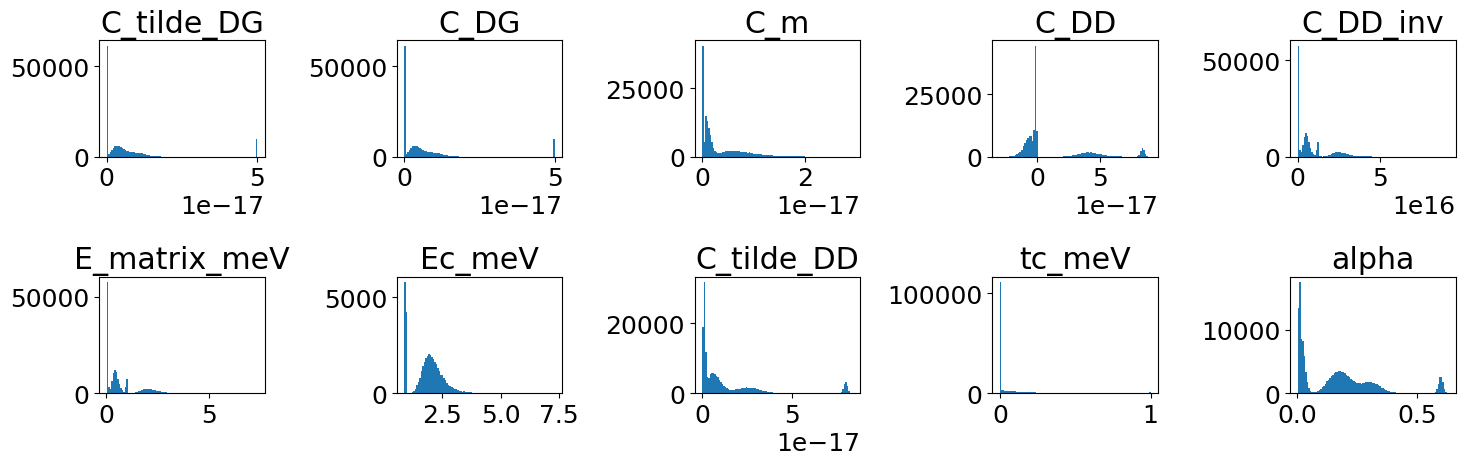

In [15]:
fig, axes = plt.subplots(2, len(capacitance_data.keys())//2, figsize=(15, 5))
axes = axes.flatten()
for key, ax in zip(capacitance_data.keys(), axes):
    ax.hist(capacitance_data[key].flatten(), bins=100)
    ax.set_title(key)
    #if key == "tc_meV":
    #    ax.set_xscale("log")
plt.tight_layout()
plt.show()  

## QDARTs connect


In [16]:
import numpy as np

def deploy_experiment(Nd, Ns, params, system_matrices):

    capacitance_config = {
            "C_DD" : np.abs(system_matrices["C_tilde_DD"])*1e18,  #dot-dot capacitance matrix
            "C_Dg" : np.abs(system_matrices["C_DG"])*1e18,  #dot-gate capacitance matrix
            "ks" : None,       #distortion of Coulomb peaks. NOTE: If None -> constant size of Coublomb peak 
    }
    tunneling_config = {
            "tunnel_couplings": system_matrices["tc_meV"]*1e-3, #tunnel coupling matrix
            "temperature": params["temperature"],                   #temperature in Kelvin
            "energy_range_factor": params["energy_range_factor"],  #energy scale for the Hamiltonian generation. NOTE: Smaller -> faster but less accurate computation 
    }
    sensor_config = {
            "sensor_dot_indices": [Nd + k for k in range(Ns)],  #Indices of the sensor dots
            "sensor_detunings": params["sensor_detunings"],  #Detuning of the sensor dots
            "noise_amplitude": params["noise_amplitude"], #Noise amplitude for the sensor dots in eV
            "peak_width_multiplier": params["peak_width_multiplier"],  #Width of the sensor peaks in the units of thermal broadening m *kB*T/0.61.
    }




    
    exp = Experiment(capacitance_config, tunneling_config, sensor_config)
    return exp




In [17]:
#deployment
from sympy import N


Nexperiments = 5
Nd = 3
Ns = 1

params = {
    "temperature": 0.1,
    "energy_range_factor": 4,
    "sensor_detunings": [1],
    "noise_amplitude": {"fast_noise": 0.5*1e-16, "slow_noise": 1e-17},
    "peak_width_multiplier": 80,
}


experiments_to_run = []

for ind in range(Nexperiments): 
        ind = np.random.randint(0,len(capacitance_data["C_DD"]))
        system_matrices = {"C_tilde_DD": capacitance_data["C_tilde_DD"][ind], 
                        "C_DG": capacitance_data["C_DG"][ind], 
                        "tc_meV": capacitance_data["tc_meV"][ind]}
        experiment = deploy_experiment(Nd, Ns, params, system_matrices)
        experiments_to_run.append(experiment)



from itertools import combinations

# Determine all Cartesian plane cuts that only involve target gates
target_gate_indices = [idx for idx in range(Ndots + Nsensors) if idx != Ndots]
plane_axis_specs = list(combinations(target_gate_indices, 2))

EXPERIMENT INITIALIZED
-----------------------

                Capacitance model deployed with the following parameters:
                Dot-dot capacitances: 
                [[30.18458972  7.01011708  4.19224643  2.21681782]
 [ 7.01011708 27.10315187  5.13106513  0.66386014]
 [ 4.19224643  5.13106513 24.30365415  0.79574383]
 [ 2.21681782  0.66386014  0.79574383 79.93190021]]
                Dot-gate capacitances: 
                [[11.39812265  4.82081348  4.02125463  0.        ]
 [ 3.96629766 12.1483085   3.24344053  0.        ]
 [ 4.52517755  3.31067606  8.74651919  0.        ]
 [ 0.          0.          0.         50.        ]]
                Size of Coulomb peaks V[n] is constant
                

            Sensor model deployed with the following parameters:   
            Sensor dot indices: [3]
            Sensor detunings: [1000.] meV
            Coulomb peak width: 2.18 meV
            Slow noise amplitude: 0.0 ueV
            Fast noise amplitude: 0.0 ueV
            S

In [18]:
capacitance_data["dot_distances_batch"][6]

array([[0.00000000e+00, 1.09758774e-07, 1.02196927e-07, 2.06494530e-07],
       [1.09758774e-07, 0.00000000e+00, 1.46227983e-07, 2.15891633e-07],
       [1.02196927e-07, 1.46227983e-07, 0.00000000e+00, 1.05984078e-07],
       [2.06494530e-07, 2.15891633e-07, 1.05984078e-07, 0.00000000e+00]])

4


Rastering CSD: 100%|██████████| 10000/10000 [00:00<00:00, 17534.88it/s]


[[[0.01257287]
  [0.01257353]
  [0.01257416]
  ...
  [0.01257493]
  [0.01257594]
  [0.01257075]]

 [[0.01257357]
  [0.01257421]
  [0.01257483]
  ...
  [0.01257546]
  [0.01257619]
  [0.01256463]]

 [[0.01257425]
  [0.01257487]
  [0.01257547]
  ...
  [0.01257598]
  [0.01257269]
  [0.01256519]]

 ...

 [[0.01258163]
  [0.01258201]
  [0.01258236]
  ...
  [0.01258302]
  [0.01258333]
  [0.01258363]]

 [[0.01258199]
  [0.01258235]
  [0.01258268]
  ...
  [0.01258335]
  [0.01258364]
  [0.01258393]]

 [[0.01258233]
  [0.01258264]
  [0.01258105]
  ...
  [0.01258366]
  [0.01258394]
  [0.01258421]]]


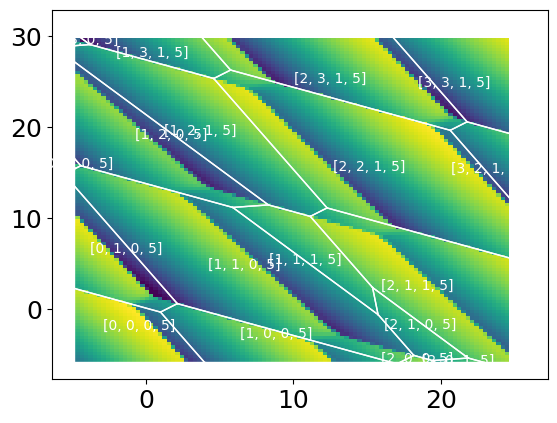

Rastering CSD: 100%|██████████| 10000/10000 [00:00<00:00, 19796.23it/s]


[[[0.01257674]
  [0.01257708]
  [0.01257741]
  ...
  [0.01256716]
  [0.01256767]
  [0.01256817]]

 [[0.01257733]
  [0.01257766]
  [0.01257798]
  ...
  [0.01256794]
  [0.01256844]
  [0.01256893]]

 [[0.01257791]
  [0.01257822]
  [0.01257853]
  ...
  [0.01256871]
  [0.0125692 ]
  [0.01256968]]

 ...

 [[0.01258336]
  [0.01258355]
  [0.01258373]
  ...
  [0.01257453]
  [0.01257477]
  [0.01257503]]

 [[0.01258366]
  [0.01258382]
  [0.01258233]
  ...
  [0.01257483]
  [0.01257511]
  [0.01257539]]

 [[0.01258391]
  [0.01258185]
  [0.01257328]
  ...
  [0.01257522]
  [0.01257552]
  [0.01257583]]]


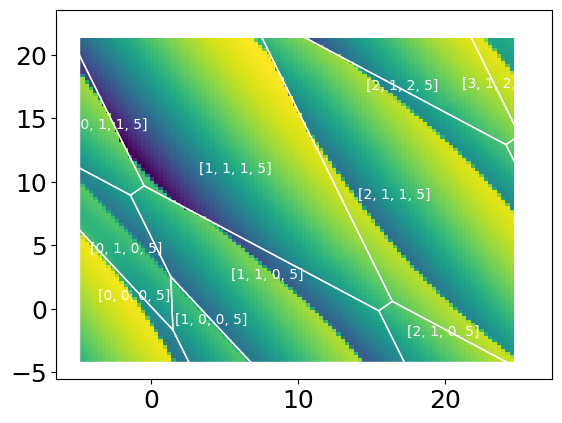

Rastering CSD: 100%|██████████| 10000/10000 [00:00<00:00, 19570.09it/s]


KeyboardInterrupt: 

In [19]:
resolution  = 100

def plane_axes_from_pair(pair):
    axes = np.zeros((2, Ndots + Nsensors), dtype=float)
    axes[0, pair[0]] = 1.0
    axes[1, pair[1]] = 1.0
    return axes


for exprm in experiments_to_run:
    cap_sim = exprm.capacitance_sim
    print(cap_sim.num_dots)
    base_state_hint = np.zeros(cap_sim.num_dots, dtype=int)
    base_state_hint[Ndots] = 5
    base_state = cap_sim.find_state_of_voltage(np.zeros(cap_sim.num_dots), state_hint=base_state_hint)

    base_state[Ndots] = 5


    transition_vectors = np.asarray(get_virtual_gate_transitions(
        alpha = capacitance_data["alpha"][i],
        Nd = np.shape(capacitance_data["C_DD"][i])[0],
        C_DD_inv = capacitance_data["C_DD_inv"][i],
        base_charge_state = base_state,
    ))

    v1_offset = -np.sum(transition_vectors, axis=0)
    plane_entries = []
    coulomb_diamond_sizes = get_coulomb_diamond_sizes(capacitance_data["C_DD_inv"][i], capacitance_data["alpha"][i])


    for pair in plane_axis_specs:
        axes = plane_axes_from_pair(pair)
        span_x = coulomb_diamond_sizes[pair[0]]
        span_y = coulomb_diamond_sizes[pair[1]]


        x_voltages = np.linspace(-0.4*span_x, 2.1 * span_x, resolution)  #NotE: why span is larger for 3rd cut?
        y_voltages = np.linspace(-0.4*span_y, 2.1 * span_y, resolution)
    
    
        xout, yout, _, polytopes, sensor_values, _ = exprm.generate_CSD(
                plane_axes=axes,
                x_voltages=x_voltages,
                y_voltages=y_voltages,
                v_offset=v1_offset,
                compute_polytopes=True,
                compensate_sensors=False,
                use_virtual_gates=False,
                use_sensor_signal=True,
            )  

        print(sensor_values)
        plt.pcolormesh(1e3*xout-1e3*v1_offset[pair[0]],1e3*yout-1e3*v1_offset[pair[1]],sensor_values[:,:,0].T)
        plot_polytopes(plt.gca(), polytopes, axes_rescale=1e3)  # plot the polytopes to see the constant occupation regions
        plt.show()


## SCRAB ------------


In [20]:
capacitance_data.keys()

dict_keys(['C_tilde_DG', 'C_DG', 'C_m', 'C_DD', 'C_DD_inv', 'E_matrix_meV', 'Ec_meV', 'C_tilde_DD', 'tc_meV', 'alpha'])

In [1]:
%load_ext autoreload
%autoreload 2

# add Code folder, if the package is not installed.
import sys
sys.path.append('qdarts/src/qdarts/')


In [2]:
import pathlib

# import main class and plotting function
from experiment import Experiment
from plotting import plot_polytopes

# import standard libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


ModuleNotFoundError: No module named 'qdarts.simulator'

In [5]:
params = {
    # Geometry
    "d_mean_nm": 100.0,
    "d_std_nm": 20.0,
    "d_min_nm": 60.0,

    # Gate Capacitance
    "sensor_idx": 3,
    "sensor_gate_idx": 3,
    "C_dg_diag_mean": 2.0e-18,
    "C_dg_diag_std": 0.5e-18,
    "C_dg_cross_mean": 0.1e-18,
    "C_dg_cross_std": 0.05e-18,
    "C_dg_sensor_gate_fixed": 3.0e-18,

    # Dot-Dot Capacitance (Optional, will use defaults if not present)
    "C_m_nn_mean": 0.3e-18, # Overriding the default of 0.1e-18 * 3
    "C_m_nn_std": 0.15e-18, # Overriding the default

    # Tunnel Coupling
    "tc_C_tilde_DD_slope": 5e15,
    "tc_std": 0.1, # This will be used as a fractional std (10%)
}

In [6]:

from itertools import combinations

# Determine all Cartesian plane cuts that only involve target gates
target_gate_indices = [idx for idx in range(Nd) if idx != params["sensor_gate_idx"]]
plane_axis_specs = list(combinations(target_gate_indices, 2))

def plane_axes_from_pair(pair):
    axes = np.zeros((2, Nd), dtype=float)
    axes[0, pair[0]] = 1.0
    axes[1, pair[1]] = 1.0
    return axes


(10000, 4, 2)


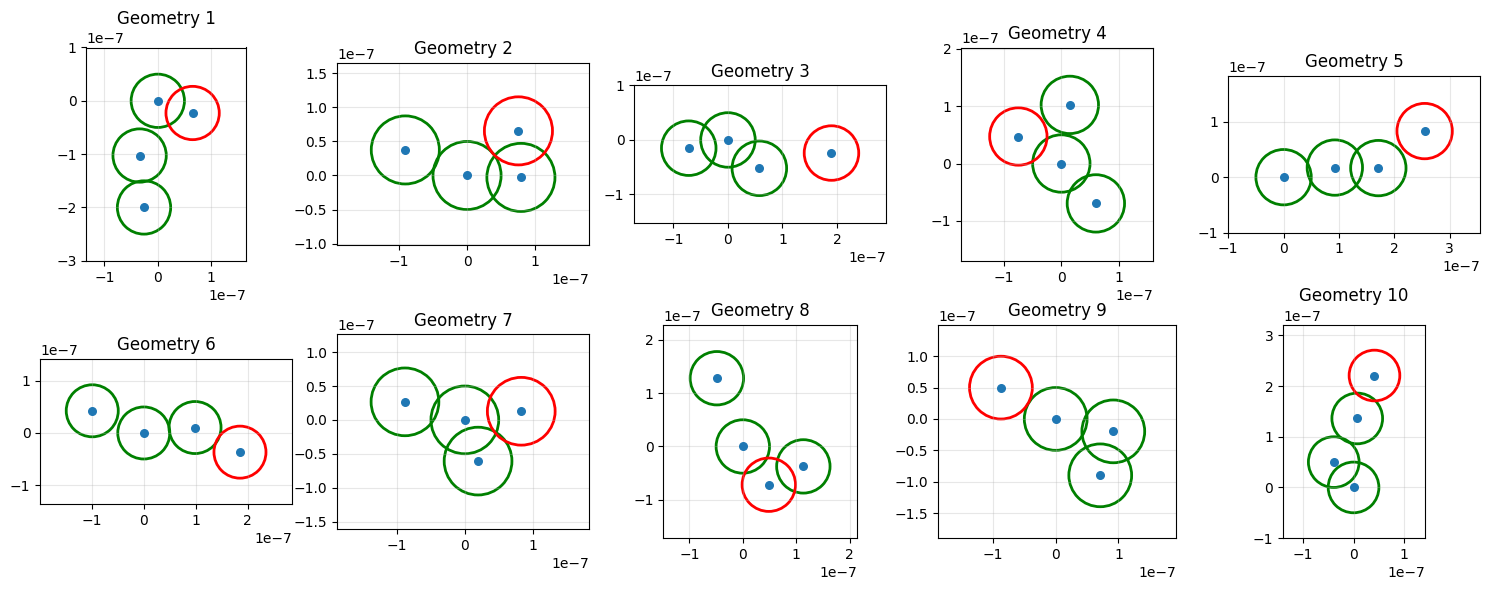

In [9]:

from typing import List, Dict, Any


def generate_random_csd_samples(num_samples: int, resolution: int = 101, seed: int | None = None) -> List[Dict[str, Any]]:
    rng = np.random.default_rng(seed)
    samples: List[Dict[str, Any]] = []

    for sample_idx in range(num_samples):
        np.random.seed(int(rng.integers(0, 2**32 - 1)))
        model = QuantumDotModel(Nd, Ng, params, kT_meV=0.025)

        cap_cfg = dict(capacitance_config)
        cap_cfg["C_DD"] = np.abs(model.C_DD * 1e18)
        cap_cfg["C_Dg"] = np.abs(model.C_DG * 1e18)

        tun_cfg = dict(tunneling_config)
        tun_cfg["tunnel_couplings"] = model.tc_meV * 1e-3

        experiment = Experiment(cap_cfg, tun_cfg, sensor_config, print_logs=False)
        cap_sim = experiment.capacitance_sim

        base_voltage = np.zeros(Ng)


        base_state_hint = np.zeros(cap_sim.num_dots, dtype=int)
        base_state_hint[params["sensor_gate_idx"]] = 6
        base_state = cap_sim.find_state_of_voltage(base_voltage, state_hint=base_state_hint)

        base_state[-1] = 5
        transition_vectors = np.asarray(
            model.get_virtual_gate_transitions(base_charge_state=base_state),
            dtype=float,
        )
        v1_offset = -np.sum(transition_vectors, axis=0)
        plane_entries = []
        coulomb_diamond_sizes = model.get_coulomb_diamond_sizes()
        for pair in plane_axis_specs:
            axes = plane_axes_from_pair(pair)
            span_x = coulomb_diamond_sizes[pair[0]]
            span_y = coulomb_diamond_sizes[pair[1]]



            x_voltages = np.linspace(-0.4*span_x, 2.1 * span_x, resolution)
            y_voltages = np.linspace(-0.4*span_y, 2.1 * span_y, resolution)
 
            xout, yout, _, polytopes, sensor_values, _ = experiment.generate_CSD(
                plane_axes=axes,
                x_voltages=x_voltages,
                y_voltages=y_voltages,
                v_offset=v1_offset,
                compute_polytopes=True,
                compensate_sensors=False,
                use_virtual_gates=False,
                use_sensor_signal=True,
            )  
            
            plt.pcolormesh(1e3*xout-1e3*v1_offset[pair[0]],1e3*yout-1e3*v1_offset[pair[1]],sensor_values[:,:,0].T)
            plot_polytopes(plt.gca(), polytopes, axes_rescale=1e3)  # plot the polytopes to see the constant occupation regions
            plt.show()
          

            plane_entries.append(
                {
                    "pair": pair,
                    "plane_axes": axes.copy(),
                    "span_x": span_x,
                    "span_y": span_y,
                    "transition_vector_x": transition_vectors[pair[0]].copy(),
                    "transition_vector_y": transition_vectors[pair[1]].copy(),
                    "x_voltages": xout,
                    "y_voltages": yout,
                    "sensor_signal": sensor_values[:, :, 0],
                    "polytopes": polytopes,
                }
            )

        samples.append(
            {
                "sample_index": sample_idx,
                "base_state": base_state,
                "base_voltage": base_voltage,
                "v1_offset": v1_offset,
                "transition_vectors": transition_vectors,
                "capacitance_config": cap_cfg,
                "tunneling_config": tun_cfg,
                "plane_entries": plane_entries,
            }
        )

    return samples


Rastering CSD: 100%|██████████| 10201/10201 [00:01<00:00, 9748.51it/s]


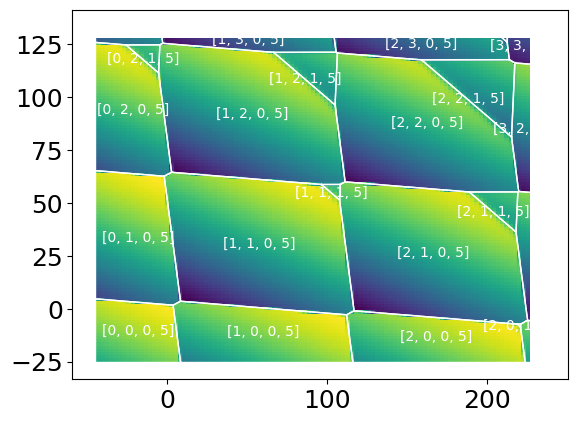

Rastering CSD: 100%|██████████| 10201/10201 [00:00<00:00, 11268.29it/s]


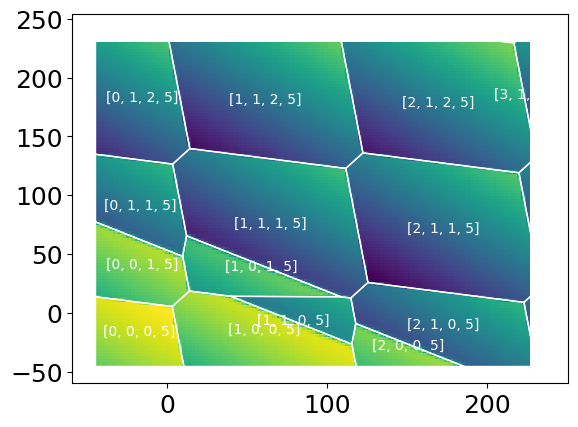

Rastering CSD: 100%|██████████| 10201/10201 [00:01<00:00, 9609.90it/s]


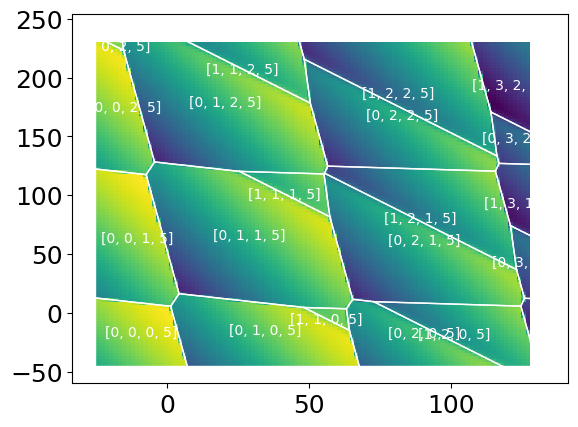

Rastering CSD: 100%|██████████| 10201/10201 [00:00<00:00, 10373.71it/s]


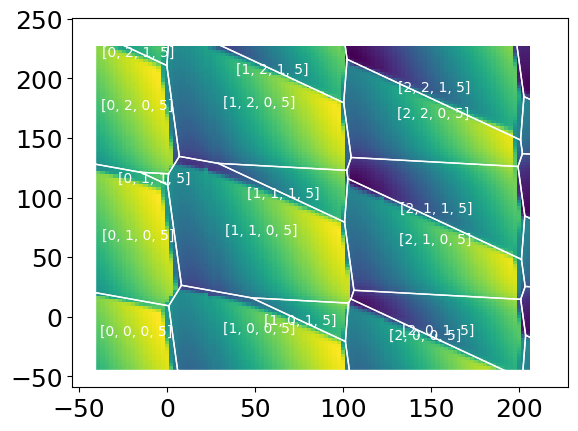

Rastering CSD: 100%|██████████| 10201/10201 [00:00<00:00, 12125.91it/s]


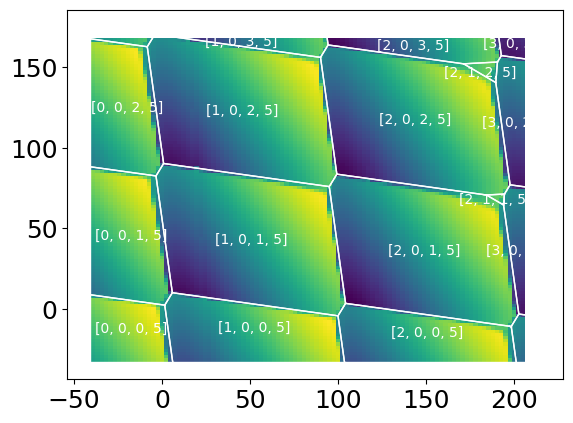

Rastering CSD: 100%|██████████| 10201/10201 [00:00<00:00, 12807.78it/s]


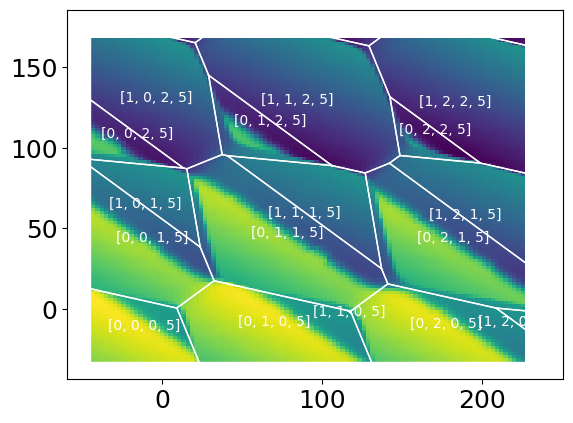

Rastering CSD: 100%|██████████| 10201/10201 [00:00<00:00, 10571.66it/s]


In [ ]:

N_samples = 4
csd_samples = generate_random_csd_samples(N_samples, resolution=101, seed=42)

print(f"Generated {len(csd_samples)} devices.")
print(f"Each device yields {len(plane_axis_specs)} plane cuts.")
first_sample = csd_samples[0]
print("v1_offset (gate voltages for reference):", np.round(first_sample["v1_offset"], 6))
first_plane = first_sample["plane_entries"][0]
print("Example plane pair:", first_plane["pair"],
      "| span_x=", round(first_plane["span_x"], 6),
      "| span_y=", round(first_plane["span_y"], 6))


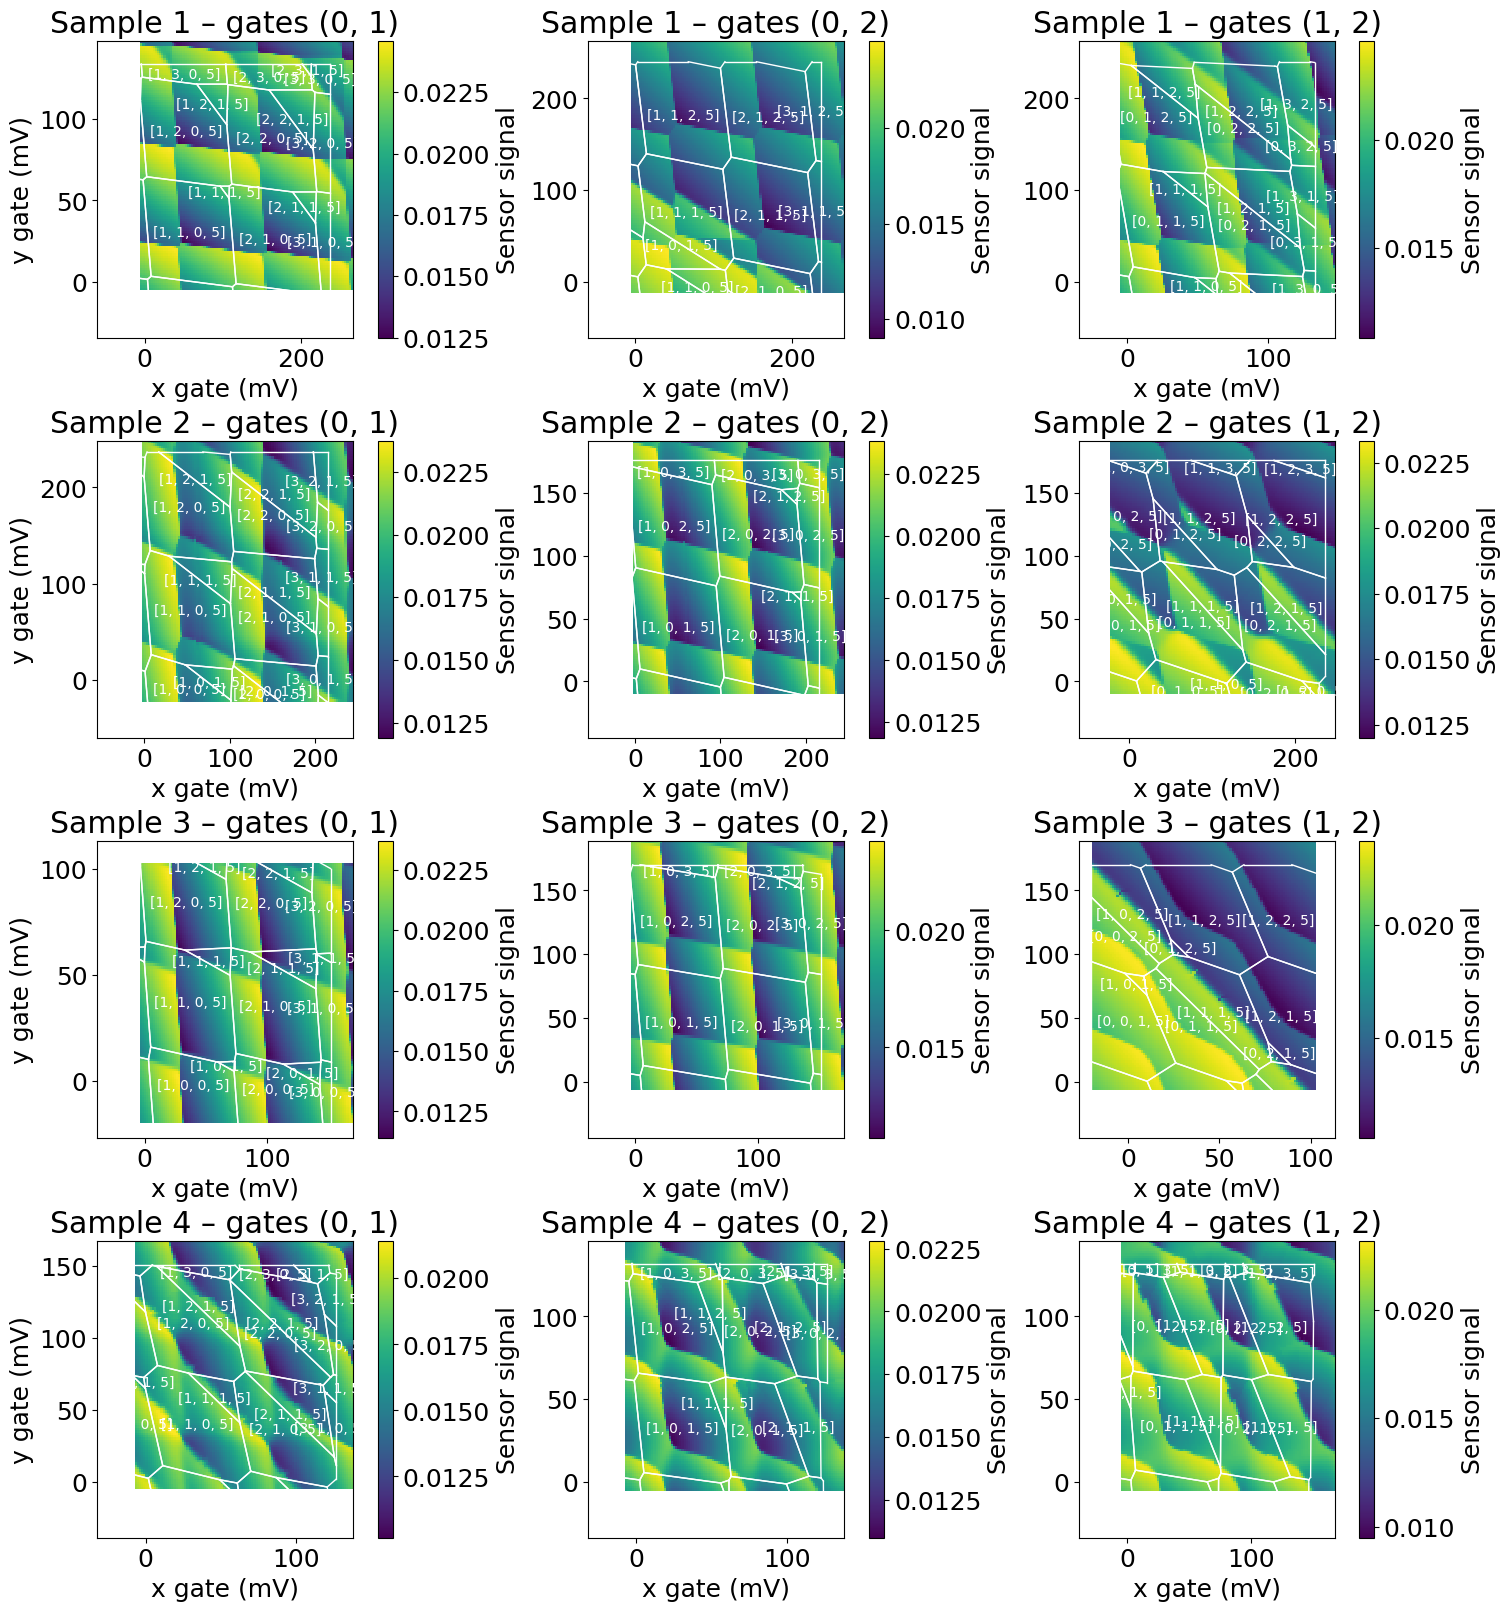

In [ ]:
# HERE WE VISUALISE 4 realisations of the CSD 

fig, axes = plt.subplots(N_samples, len(plane_axis_specs), figsize=(5*len(plane_axis_specs), 4*N_samples),
                         constrained_layout=True)

for sample_idx, sample in enumerate(csd_samples):
    for axis_idx, plane in enumerate(sample["plane_entries"]):
        ax = axes[sample_idx, axis_idx] if N_samples > 1 else axes[axis_idx]
        sensor_signal = plane["sensor_signal"].T
        xout = plane["x_voltages"]
        yout = plane["y_voltages"]
        v1_offset = sample["v1_offset"]
        pair = plane["pair"]
        
        
        pcm = ax.pcolormesh(1e3*xout-1e3*v1_offset[pair[0]],1e3*yout-1e3*v1_offset[pair[1]],sensor_signal)
        
        plot_polytopes(ax, plane["polytopes"], axes_rescale=1e3)  # plot the polytopes to see the constant occupation regions

        if axis_idx == 1:
            ax.set_title(f"Sample {sample_idx+1}")

  
plt.show()


# Test geometry generation


In [12]:
qd = QuantumDotModel(4,4, params)

In [4]:
generate_dot_distances_2d()

TypeError: _generate_dot_distances_2d() missing 1 required positional argument: 'self'